In [1]:
# Import classes for generating sequences
import torch
from torch import nn
from GenerateVT import GenerateVT
from MassFricParams import MassFricParams
from TimeSequenceGen import TimeSequenceGen
from TimeSequenceGen_NN import TimeSequenceGen_NN
from matplotlib import pyplot as plt
from matplotlib import rc

# For plotting
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [7]:
# Generating a VT sequence for the spring slider
VTkwgs = {
        'logVDist' : True, 
        'Vrange' : [-2., 1.], 
        'Trange' : [0., 2.0], 
        'NofTpts' : 10, 
        'flag' : 'simple', 
        'nOfTerms' : 3, 
}
myVT = GenerateVT(VTkwgs)

In [8]:
# Generate a time sequence
# Spring slider parameters
kmg = [5000., 1., 9.8]

# Rate and state parameters
RSParams = [0.011, 0.016, 1. / 1.e-2, 0.58]

# Solver specific parameters
rtol, atol = 1.e-8, 1.e-10 
regularizedFlag = False
solver = 'rk4'

# Initial condition
y0 = torch.tensor([0., 1., 1. / RSParams[2]])
myMFParams = MassFricParams(kmg, myVT.VT, RSParams, y0, lawFlag = "aging", regularizedFlag = True)

# Set for my sequence
myTimeSeq = TimeSequenceGen(myVT.Trange[1], 
                            10, 
                            myMFParams, 
                            rtol, 
                            atol, 
                            regularizedFlag, 
                            solver)

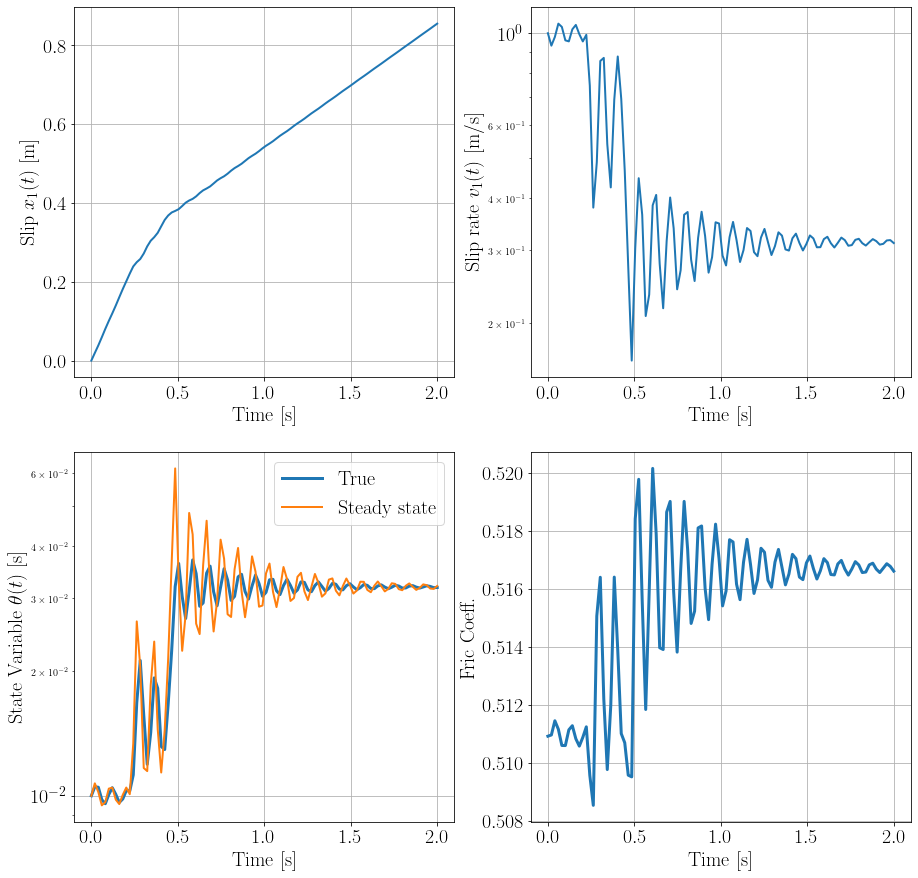

In [9]:
myTimeSeq.plotY(myTimeSeq.t, myTimeSeq.default_y)

In [10]:
# Load the learnt model from storage
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare, FricCorrection

# Load learnt model
def load_model(modelPrefix, mapDevice=torch.device("cuda:0"), dim_xi=1, dict_flag=False):
    if dict_flag:
        
        PATH = "./model/" + modelPrefix + "_dimXi_" + str(dim_xi) + "_dict"
        myModel = torch.load(PATH + "/model.pth", map_location=torch.device("cpu"))

        del myModel.W, myModel.D, myModel.D_dagger
        
        myModel.W = PP(myModel.NNs_W, input_dim = 1, output_dim = 1)
        myModel.D = PP(myModel.NNs_D, input_dim = myModel.dim_xi, output_dim = 1)
        myModel.D_dagger = PP(myModel.NNs_D_dagger, input_dim = 1 + myModel.dim_xi, output_dim = 1)

        # Multi-GPU data parallel
        myModel.W = nn.DataParallel(myModel.W)
        myModel.D = nn.DataParallel(myModel.D)
        myModel.D_dagger = nn.DataParallel(myModel.D_dagger)

        myModel.load_nns(PATH, mapDevice)
    else:
        myModel = torch.load("./model/" + modelPrefix + "_dimXi_" + str(dim_xi) + ".pth", 
                             map_location=mapDevice)

    return myModel

In [11]:
# Try loading the model
modelPrefix = "Trial0216_combined_800"
# modelPrefix = "Trial0216_smallDRS_smallA_400"
dim_xi = 1
myModel = load_model(modelPrefix, torch.device("cpu"), dim_xi, True)

In [12]:
# Compute slip rate for the same input sequence using NN model
myTimeSeqNN = TimeSequenceGen_NN(myVT.Trange[1], 
                                10, 
                                myMFParams, 
                                myModel, 
                                rtol, 
                                atol, 
                                solver, 
                                fOffSet = 0.5109, 
                                scaling_factor = 50.)

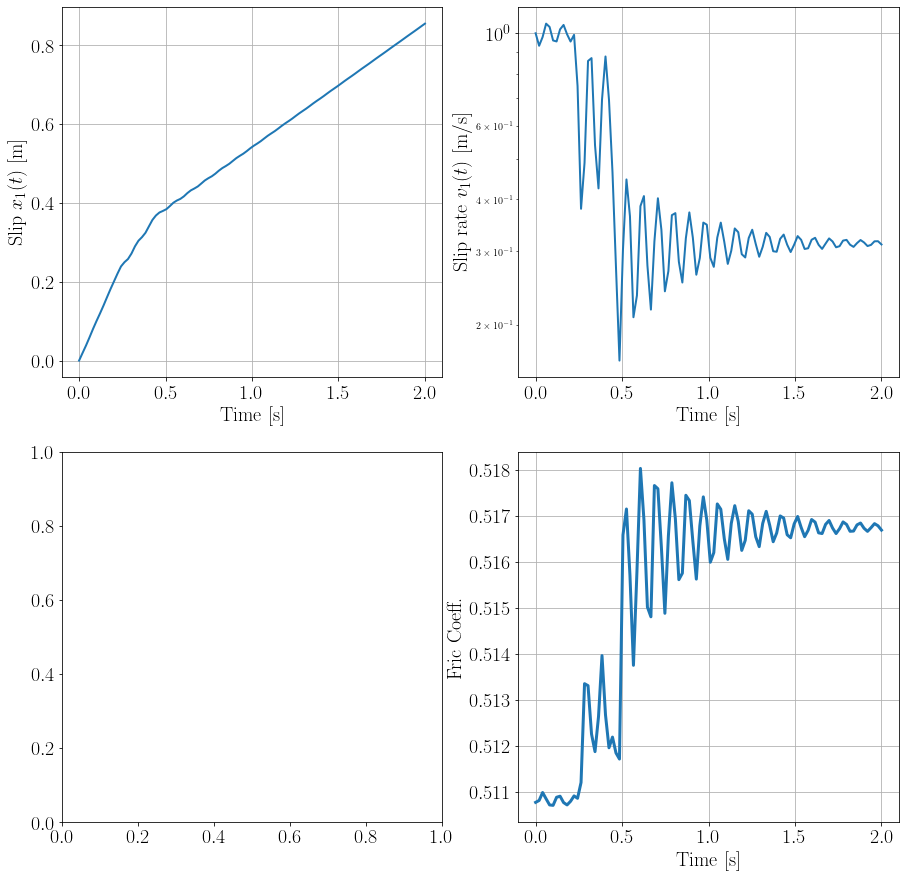

In [13]:
myTimeSeqNN.plotY(myTimeSeqNN.t, myTimeSeqNN.default_y)

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

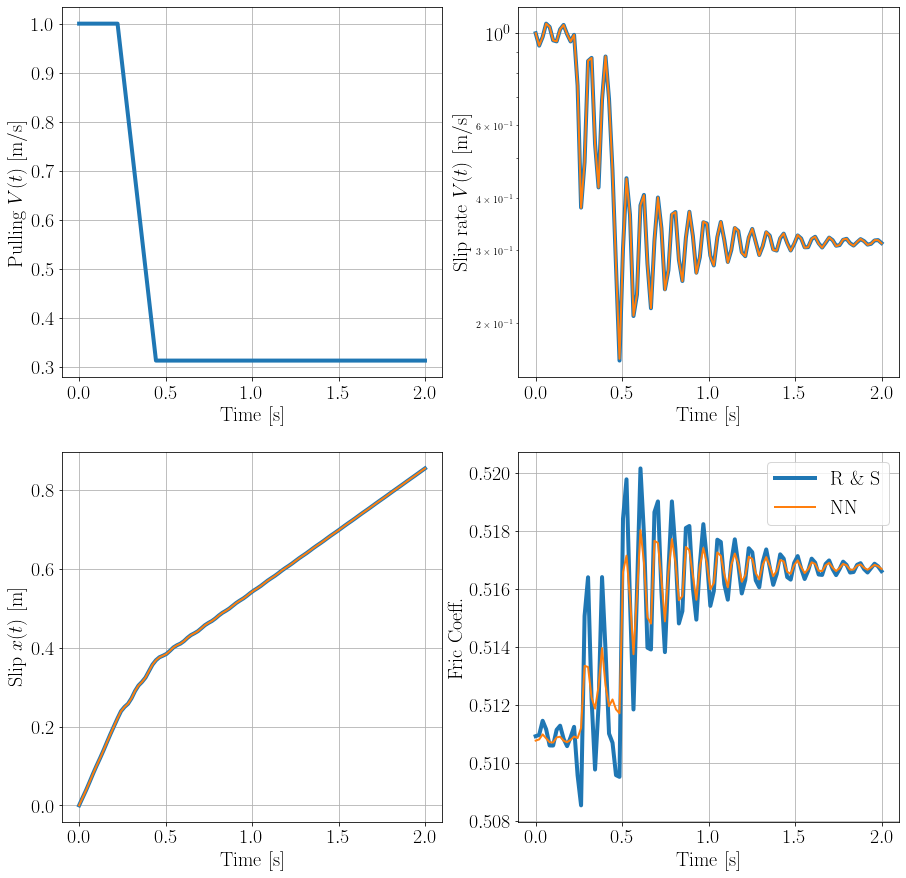

In [15]:
# Plot the sequences from NN and rate-and-state friction on the same plot
from FrictionNNModels import plotGenVXFric
plotGenVXFric(myVT.VT[0, :], myVT.VT[1, :], myTimeSeq.t, 
              [myTimeSeq.default_y[1,:], myTimeSeqNN.default_y[1,:]], 
              [myTimeSeq.default_y[0,:], myTimeSeqNN.default_y[0,:]], 
              [myTimeSeq.Fric, myTimeSeqNN.Fric])


# Test on more sequences


In [22]:
import random

# Store the results
NofSeqs = 200
y_RSs = []
y_NNs = []
Fric_RSs = []
Fric_NNs = []
myVTs = []
ks = []
ts = []

# Start generating sequences
id = 0
while id < NofSeqs:
    k = 10. ** (random.random() * 3. + 1.)
    kmg = [k, 1., 9.8]
    myVT = GenerateVT(VTkwgs)
    myMFParams = MassFricParams(kmg, myVT.VT, RSParams, y0, lawFlag = "aging", regularizedFlag = True)

    # Set for my sequence
    myTimeSeq = TimeSequenceGen(myVT.Trange[1], 
                                10, 
                                myMFParams, 
                                rtol, 
                                atol, 
                                regularizedFlag, 
                                solver)
    
    # Check if there is nan in myTimeSeq
    if torch.any(torch.isnan(myTimeSeq.default_y)):
        continue
    # Compute slip rate for the same input sequence using NN model
    myTimeSeqNN = TimeSequenceGen_NN(myVT.Trange[1], 
                                        10, 
                                        myMFParams, 
                                        myModel, 
                                        rtol, 
                                        atol, 
                                        solver, 
                                        fOffSet = 0.5109, 
                                        scaling_factor = 50.)
    
    # Check if there is nan in myTimeSeqNN
    if torch.any(torch.isnan(myTimeSeqNN.default_y)):
        continue
    
    # Store the results
    y_RSs.append(myTimeSeq.default_y)
    y_NNs.append(myTimeSeqNN.default_y)
    Fric_RSs.append(myTimeSeq.Fric)
    Fric_NNs.append(myTimeSeqNN.Fric)
    myVTs.append(myVT)
    ks.append(k)
    ts.append(myTimeSeq.t)

    # Update id
    id += 1
    if id % 10 == 0:
        print("Finished sampling {0} sequences.".format(id), flush=True)

Finished sampling 10 sequences.
Finished sampling 20 sequences.
Finished sampling 30 sequences.
Finished sampling 40 sequences.
Finished sampling 50 sequences.
Finished sampling 60 sequences.
Finished sampling 70 sequences.
Finished sampling 80 sequences.
Finished sampling 90 sequences.
Finished sampling 100 sequences.
Finished sampling 110 sequences.
Finished sampling 120 sequences.
Finished sampling 130 sequences.
Finished sampling 140 sequences.
Finished sampling 150 sequences.
Finished sampling 160 sequences.
Finished sampling 170 sequences.
Finished sampling 180 sequences.
Finished sampling 190 sequences.
Finished sampling 200 sequences.


In [23]:
# save results
res = {
    'y_RSs' : y_RSs, 
    'y_NNs' : y_NNs, 
    'Fric_RSs' : Fric_RSs, 
    'Fric_NNs' : Fric_NNs, 
    'myVTs' : myVTs, 
    'ks' : ks, 
    'RSParams' : RSParams,
    'rtol' : rtol, 
    'atol' : atol,
    'ts' : ts, 
    'regularizedFlag' : regularizedFlag, 
    'solver' : solver, 
}

torch.save(res, './data/testSpringSlider0306_200.pth')

In [16]:
# Report relative L-2 error on friction coefficient, slip rate on the slider
res = torch.load('./data/testSpringSlider0306_200.pth')

# Relative L2 error
def relativeL2(y, y_true, t):
    ans = torch.pow(
        torch.trapz(torch.pow(y - y_true, 2), t) / torch.trapz(torch.pow(y_true, 2), t), 
        0.5
    )
    return ans

# Report relative L2 error in x, V, and friction
err_x = []
err_V = []
err_Fric = []
fOffSet, scaling_factor = 0.5109, 50.

for i in range(len(res['ks'])):
    this_NN_Fric = (res['Fric_NNs'][i] - fOffSet) * scaling_factor + fOffSet
    this_RS_Fric = (res['Fric_RSs'][i] - fOffSet) * scaling_factor + fOffSet

    err_x.append(relativeL2(res['y_NNs'][i][0, :], res['y_RSs'][i][0, :], res['ts'][i]))
    err_V.append(relativeL2(res['y_NNs'][i][1, :], res['y_RSs'][i][1, :], res['ts'][i]))
    err_Fric.append(relativeL2(this_NN_Fric, this_RS_Fric, res['ts'][i]))

# Report the mean and standard deviation in L2 errors
std, mean = torch.std_mean(torch.tensor(err_x))
print("Mean, std of L2 error in x: {0}, {1}".format(mean, std))
std, mean = torch.std_mean(torch.tensor(err_V))
print("Mean, std of L2 error in V: {0}, {1}".format(mean, std))
std, mean = torch.std_mean(torch.tensor(err_Fric))
print("Mean, std of L2 error in Friction: {0}, {1}".format(mean, std))


Mean, std of L2 error in x: 5.757865801570006e-05, 6.352925265673548e-05
Mean, std of L2 error in V: 0.0017069305758923292, 0.0017897646175697446
Mean, std of L2 error in Friction: 0.0637441873550415, 0.035693082958459854


Text(0.5, 0.98, 'Sequence 8')

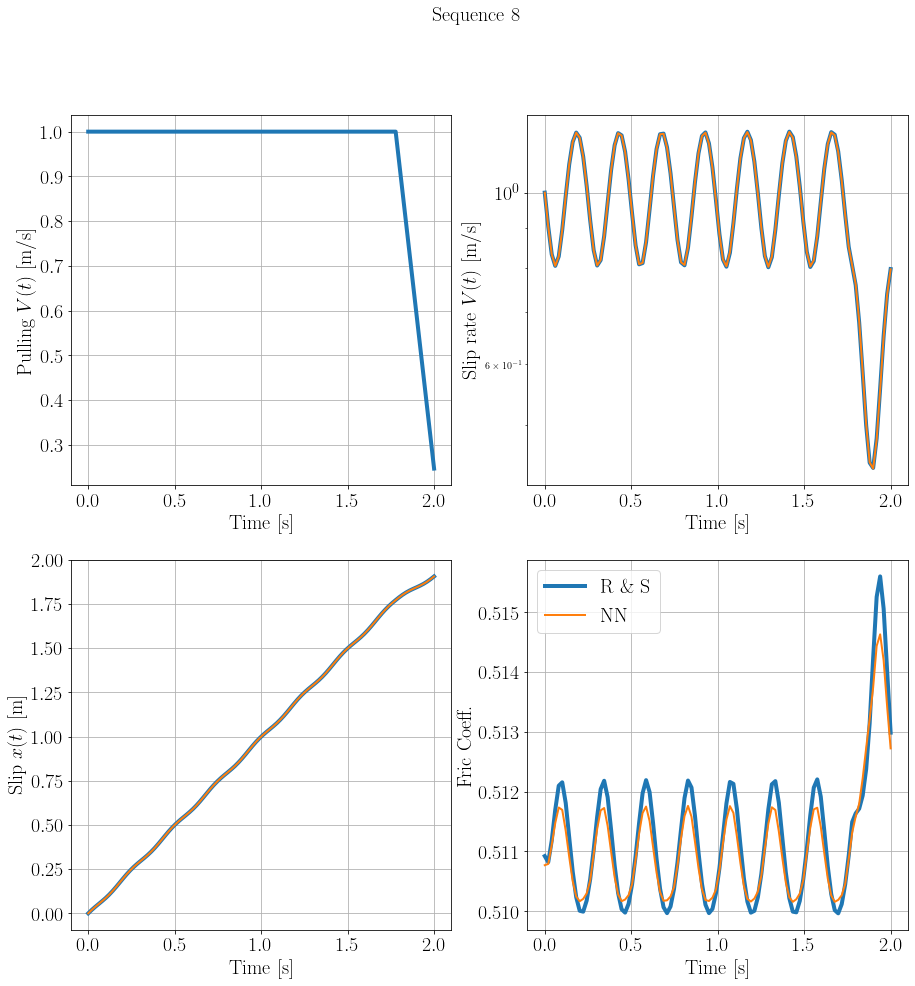

In [32]:
# Plot a sequence
# Plot the sequences from NN and rate-and-state friction on the same plot
import random
NofSeqs = 200

# Plot a sequence
idx = random.randint(0, NofSeqs)
VV, tt = res['myVTs'][idx].VT[0, :], res['myVTs'][idx].VT[1, :]
t = res['ts'][idx]
Vs = [res['y_RSs'][idx][1, :], res['y_NNs'][idx][1, :]]
xs = [res['y_RSs'][idx][0, :], res['y_NNs'][idx][0, :]]
Frics = [res['Fric_RSs'][idx], res['Fric_NNs'][idx]]
f, axs = plotGenVXFric(VV, tt, t, Vs, xs, Frics)
f.suptitle("Sequence {0}".format(idx), fontsize=20)